In [1]:
import numpy as np
import emcee
import pandas as pd
import corner
from scipy.optimize import minimize

import time
from multiprocessing import Pool

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [Zheng & Filippenko (2016)](https://arxiv.org/pdf/1612.02097.pdf), a broken power-law parameterization of SN Ia light curves is introduced. This parameterization is somewhat physically motivated, however, there are some assumptions that break down for some SNe Ia. A major advantage of this method, however, is that it covers the peak and turn-over of SN light curves, so there is no need to artificially truncate the data (to ~5 d after explosion for example) in order to only fit the early rise. 

The formulation is: 

$$L = A' \left(\frac{t - t_0}{t_b}\right)^{\alpha_\mathrm{r}} \left[1 + \left(\frac{t - t_0}{t_b}\right)^{s\alpha_\mathrm{d}}\right]^{-2/s}$$

which has a peak value when:

$$ t_p = t_b \times \left(-\frac{\alpha_1 + 1}{\alpha_2 + 1}\right)^{1/[s(\alpha_1 - \alpha_2)]} $$

$$ t_p = t_b \times \left(-\frac{1}{1 - 2\alpha_d/\alpha_r}\right)^{1/(s\alpha_d)} $$


and:

$$ \begin{align} \alpha_\mathrm{r} & = & 2(\alpha_1 + 1) \\ \alpha_\mathrm{d} & = & \alpha_1 - \alpha_2 \end{align}. $$

This parameterization has some additional constraints on the parameters, in particular, for $t \gg t_b$ if $\alpha_\mathrm{d} < \alpha_\mathrm{r}/2$ then the SN will not actually decline. $t_b$ is the break in the light curve, and is close to the rise time of the SN, assuming small $\alpha_1$ and $\alpha_2 \approx -2$.

In [2]:
def f_t(times, amplitude=25, t_b=20, t_0=0, alpha_r=2, alpha_d=2, s=2):
    time_term = (times - t_0)/t_b
    
    return amplitude * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)

In [3]:
def calc_t_p(t_b, alpha_d, alpha_r, s):
    return t_b*(-1/(1 - 2*alpha_d/alpha_r))**(1/(s*alpha_d))

In [4]:
def lnlikelihood(theta, f, t, f_err):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s, sig_0 = theta

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)/t_b
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    
    ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err**2))) - ((f - model)**2 / (2 * (sig_0**2 + f_err**2))))
    return ln_l

def lnlikelihood_no_sig0(theta, f, t, f_err):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s = theta

    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)/t_b
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    
#     ln_l = np.sum(np.log(1. / np.sqrt(2*np.pi * (f_err**2))) - ((f - model)**2 / (2 * (f_err**2))))
    ln_l = -1/2*np.sum(((f - model)/f_err)**2) + np.sum(np.log(1/np.sqrt(2*np.pi*f_err**2)))
    
#     print(-1/2*np.sum(((f_data - model)/f_unc_data)**2) + np.sum(np.log(1/np.sqrt(2*np.pi*f_unc_data**2))))
    
    return ln_l

def nll(theta, f, t, f_err):
    return -1*lnlikelihood(theta, f, t, f_err)

#Define priors on parameters  
def lnprior(theta):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s, sig_0 = theta
    if (-1e8 < t_0 < 1e8 and 0 < alpha_r < 1e8 and 
        0 < alpha_d < 1e8 and 0 < sig_0 < 1e8 and 
        -1e8 < a < 1e8 and  0 < t_b < 1e8 and 
        0 < s < 1e8 and 0 < a_prime < 1e8):
        return 0.0
    return -np.inf

def lnprior_no_sig0(theta):
    a, a_prime, t_0, t_b, alpha_r, alpha_d, s = theta
    if (-1e8 < t_0 < 1e8 and 0 < alpha_r < 1e8 and 
        0 < alpha_d < 1e8 and
        -1e8 < a < 1e8 and  0 < t_b < 1e8 and 
        0 < s < 1e8 and 0 < a_prime < 1e8):
        return 0.0
    return -np.inf

def lnposterior(theta, f, t, f_err):
    lnp = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp 

In [5]:
def gen_zheng_lc(times, baseline=0, t_exp=0, alpha_r=2, 
                 alpha_d=2, s=2, t_b=18,
                 amplitude=2e4, sigma_sys=5):
    '''
    Generate a simple SN Ia-like light curve
    
    Parameters
    ----------
    
    times : array-like
        The times at which the simulated data should be generated.
        Times are in units of days.
    
    baseline : float, optional (default=0)
        The baseline value for the flux of the transient in the 
        telescope system.
    
    t_exp : float, optional (default=0)
        The time of explosion for the SN.
    
    alpha_r : float, optional (default=2)
        Power-law index for the initial rise of the SN.

    alpha_d : float, optional (default=2)
        Power-law index for the late time decay of the SN.
    
    s : float, optional (default=2)
        Smoothing parameter for the broken power-law model.

    amplitude : float, optional (default=2e4)
        Normalizing amplitude for the SN, the default value
        is determined by assuming all default parameters, 
        and a telescope system with 25 mag zeropoint.
    
    sigma_sys : float, optional (default=5)
        The systematic noise present in the light curves due to 
        the telescope system. The default value is determined from 
        assuming a telescope limiting magnitude of 21.5.
    
    Returns
    -------
    cnts : array-like, shape=shape(times)
        The counts corresponding to the SN flux, after taking into 
        account the noise associated with the detector
    
    cnts_unc : array-like, shape=shape(times)
        Uncertainty in the number of counts from the SN
    '''
    
    cnts = np.zeros_like(times)
    cnts_unc = np.zeros_like(times)

    pre_explosion = np.logical_not(times > t_exp)
    cnts[pre_explosion] = np.random.normal(baseline, sigma_sys, size=sum(pre_explosion))
    cnts_unc[pre_explosion] = np.ones_like(times)[pre_explosion]*sigma_sys

    time_term = (times[~pre_explosion] - t_exp)/t_b
    sn_flux = amplitude * (time_term)**alpha_r * (1 + (time_term)**(s*alpha_d))**(-2/s)
    sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
    sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(baseline, sigma_sys, size=len(sn_flux))

    # total uncertainty = systematic + Poisson
    sn_uncertainties = np.hypot(np.sqrt(np.maximum(sn_with_random_noise, np.zeros_like(sn_with_random_noise))), 
                                sigma_sys)

    cnts[~pre_explosion] = sn_with_random_plus_sys
    cnts_unc[~pre_explosion] = sn_uncertainties

    return cnts, cnts_unc

In [6]:
t_obs=np.arange(-30,30, dtype=float)
ground_truth = [0, 3e4, 0, 18, 2, 2, 2]
cnts, cnts_unc = gen_zheng_lc(t_obs, amplitude=ground_truth[1], sigma_sys=50)

In [7]:
gt_with_sig_0 = ground_truth + [0]

In [8]:
nll(gt_with_sig_0, cnts, t_obs, cnts_unc)

328.66519838969026

[-1.55287711e+00  3.94749691e+04 -9.24311658e-01  1.91191488e+01
  2.40827230e+00  2.43276678e+00  1.42853404e+00  1.37128034e+00]


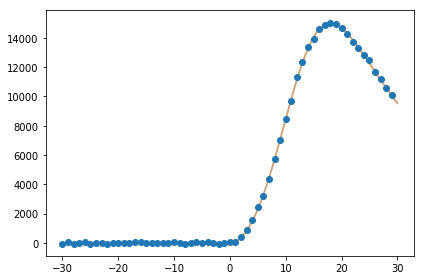

In [9]:
plt.figure()
plt.errorbar(t_obs, cnts, cnts_unc, fmt='o')
true_flux = f_t(np.linspace(0,30,1000), amplitude=ground_truth[1], 
                t_0=ground_truth[2], t_b=ground_truth[3], 
                alpha_r=ground_truth[4], alpha_d=ground_truth[5], 
                s=ground_truth[6])
plt.plot(np.linspace(0,30,1000), true_flux)

guess_0 = [0, 2*np.max(cnts), 0, 20, 1.5, 1.5, 1, 0]
ml_res = minimize(nll, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(cnts, t_obs, cnts_unc))
ml_guess = ml_res.x
print(ml_guess)

t_grid = np.linspace(-30,30,1000)
ml_model = np.empty_like(t_grid)
ml_model[t_grid <= ml_guess[2]] = ml_guess[0]
ml_model[t_grid > ml_guess[2]] = ml_guess[0] + f_t(t_grid[t_grid > ml_guess[2]], 
                                                  amplitude=ml_guess[1], 
                                        t_0=ml_guess[2], t_b=ml_guess[3], 
                                        alpha_r=ml_guess[4], alpha_d=ml_guess[5], 
                                        s=ml_guess[6])
plt.plot(np.linspace(-30,30,1000), ml_model, "0.7", alpha=0.7)
plt.tight_layout()

<IPython.core.display.Javascript object>


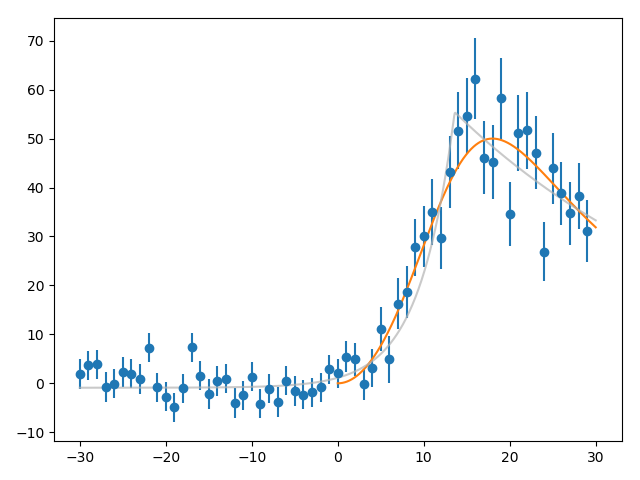

In [589]:
samp = [-9.03073057e-01,  5.63160140e+01, -8.05732270e+07,
         8.05732406e+07,  1.96768422e+07,  1.10640635e+07,
         2.84983317e+02]
plt.figure()
plt.errorbar(t_obs, cnts, cnts_unc, fmt='o')
plt.plot(np.linspace(0,30,1000), true_flux)

samp_model = np.empty_like(t_grid)
samp_model[t_grid <= samp[2]] = samp[0]
samp_model[t_grid > samp[2]] = samp[0] + f_t(t_grid[t_grid > samp[2]], 
                                                  amplitude=samp[1], 
                                        t_0=samp[2], t_b=samp[3], 
                                        alpha_r=samp[4], alpha_d=samp[5], 
                                        s=samp[6])
plt.plot(t_grid, samp_model, "0.7", alpha=0.7)
plt.tight_layout()


In [10]:
# light curve to fit
det = np.where(cnts/cnts_unc >= 4)
t_data = t_obs
f_data = cnts
f_unc_data = cnts_unc

# setup various emcee parameters

#initial guess on parameters
guess_0 = [0, 2*np.max(f_data), 0, 20, 1.5, 1.5, 1, 0]

# initialize near maximum-likelihood result
ml_res = minimize(nll, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data))
ml_guess = ml_res.x
print(ml_guess)
if ml_guess[-1] < 0:
    ml_guess[-1] *= -1

#number of walkers
nwalkers = 500
nfac = [5e-3, 5e-3, 5e-3, 5e-3, 5e-3, 5e-3, 5e-3, 5e-3]
ndim = len(ml_guess)

#initial position of walkers
pos = [ml_guess + nfac * np.random.randn(ndim) for i in range(nwalkers)]

#run initial burn-in
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
max_samples = 1000000

index = 0
autocorr = np.empty(max_samples)
old_tau = np.inf
for sample in sampler.sample(pos, iterations=max_samples, progress=True):
    if sampler.iteration % 50000:
        continue
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

[-1.55287711e+00  3.94749691e+04 -9.24311658e-01  1.91191488e+01
  2.40827230e+00  2.43276678e+00  1.42853404e+00  1.37128034e+00]


  0%|          | 2189/1000000 [00:47<6:05:56, 45.44it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
  0%|          | 2314/1000000 [00:50<5:59:49, 46.21it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 4324/1000000 [01:33<5:55:29, 46.68it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
 80%|████████  | 800000/1000000 [7:31:02<1:52:45, 29.56it/s]     


In [11]:
tau

array([ 316.73317458, 5469.10502843, 2486.91305273, 3705.49977384,
       3546.18365776, 4497.76821773, 3247.06673912,  369.34540026])

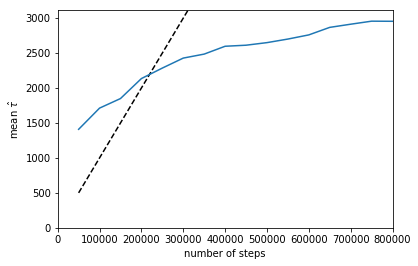

In [12]:
n = 50000*np.arange(1, index+1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

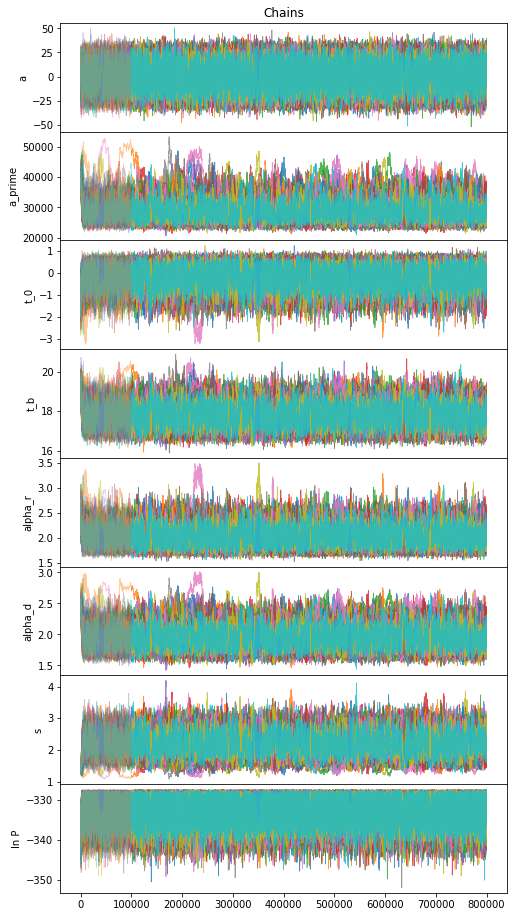

<Figure size 432x288 with 0 Axes>

In [15]:
nburn = 100000
ax = plotChains(sampler, nburn, paramsNames, nplot=50)
plt.show()
plt.tight_layout()

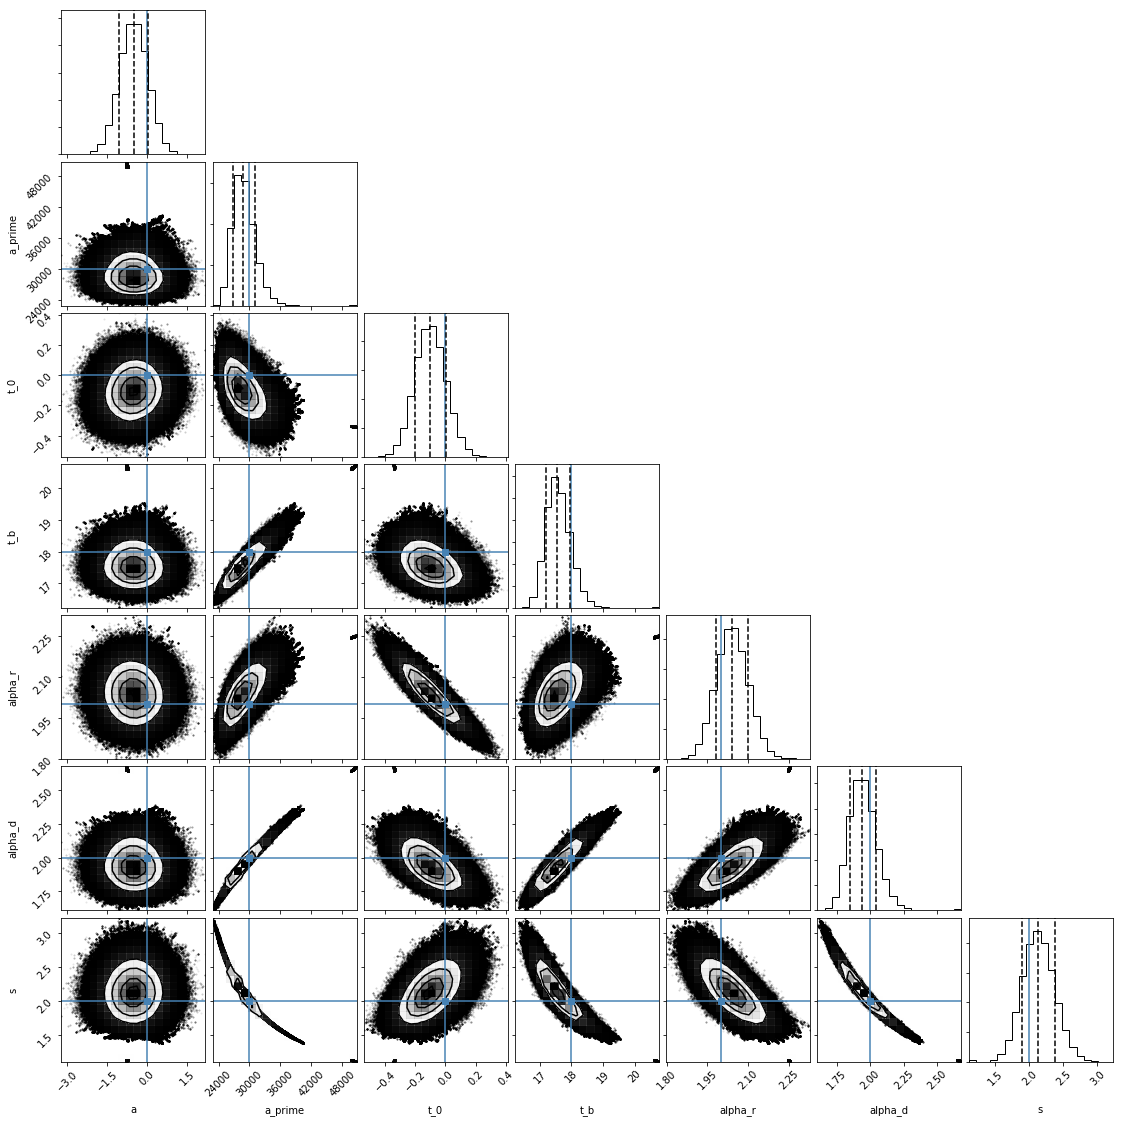

In [21]:
burnin = 75000
makeCorner(sampler, burnin, paramsNames, truths=ground_truth)
plt.show()

In [17]:
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
burn_max_post

array([-7.75866559e-01,  2.88530951e+04, -1.02891174e-01,  1.75121159e+01,
        2.04856702e+00,  1.94482147e+00,  2.10465662e+00])

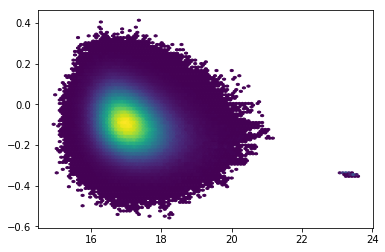

In [46]:
burnin = 50000
t_p = calc_t_p(sampler.get_chain(discard = burnin, flat=True)[:,3], 
         sampler.get_chain(discard = burnin, flat=True)[:,5], 
         sampler.get_chain(discard = burnin, flat=True)[:,4], 
         sampler.get_chain(discard = burnin, flat=True)[:,6])

plt.hexbin(t_p, sampler.get_chain(discard = burnin, flat=True)[:,2], mincnt=1)

# Run the sampler using the previous max aposteriori estimate

In [368]:
# run second burn in
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
nsamples = 15000
foo = sampler.run_mcmc(pos, nsamples)
 

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


In [369]:
# set a "burn-in" limit
burnin = 3000

samples = sampler.get_chain(discard=burnin, flat=True)

a_mc, a_prime_mc, t_0_mc, t_b_mc, alpha_r_mc, alpha_d_mc, s_mc = map(lambda v: (v[0], v[1], v[2], v[3], v[4]), 
                                                                     zip(*np.percentile(samples, [2.5, 16, 50, 84, 97.5], axis=0)))


In [370]:
print("emcee results with 68% credible regions\n \
      t_0 = {:.4f} -{:.4f} +{:.4f}\n \
      t_b = {:.4f} -{:.4f} +{:.4f}\n \
      alpha_r = {:.4f} -{:.4f} +{:.4f}\n \
      alpha_d = {:.4f} -{:.4f} +{:.4f}\n \
      a = {:.4f} -{:.4f} +{:.4f}\n \
      a_prime = {:.4f} -{:.4f} +{:.4f}\n \
      s = {:.4f} -{:.4f} +{:.4f}\n" # \
#       sig_0 = {:.4f} -{:.4f} +{:.4f}\n" \
      .format(t_0_mc[2], t_0_mc[2] - t_0_mc[1], t_0_mc[3] - t_0_mc[2], 
              t_b_mc[2], t_b_mc[2] - t_b_mc[1], t_b_mc[3] - t_b_mc[2],
              alpha_r_mc[2], alpha_r_mc[2] - alpha_r_mc[1], alpha_r_mc[3] - alpha_r_mc[2], 
              alpha_d_mc[2], alpha_d_mc[2] - alpha_d_mc[1], alpha_d_mc[3] - alpha_d_mc[2], 
              a_mc[2], a_mc[2] - a_mc[1], a_mc[3] - a_mc[2],
              a_prime_mc[2], a_prime_mc[2] - a_prime_mc[1], a_prime_mc[3] - a_prime_mc[2],
              s_mc[2], s_mc[2] - s_mc[1], s_mc[3] - s_mc[2]))#,
#               sig_0_mc[2], sig_0_mc[2] - sig_0_mc[1], sig_0_mc[3] - sig_0_mc[2]))

emcee results with 68% credible regions
       t_0 = -0.2398 -1.4086 +0.8594
       t_b = 17.3794 -1.8621 +2.9457
       alpha_r = 2.2639 -0.4863 +0.8899
       alpha_d = 2.2638 -0.7353 +0.8895
       a = -0.4523 -1.0143 +0.9512
       a_prime = 1234.1185 -510.7091 +1297.0987
       s = 1.4347 -0.6261 +1.8751



<IPython.core.display.Javascript object>


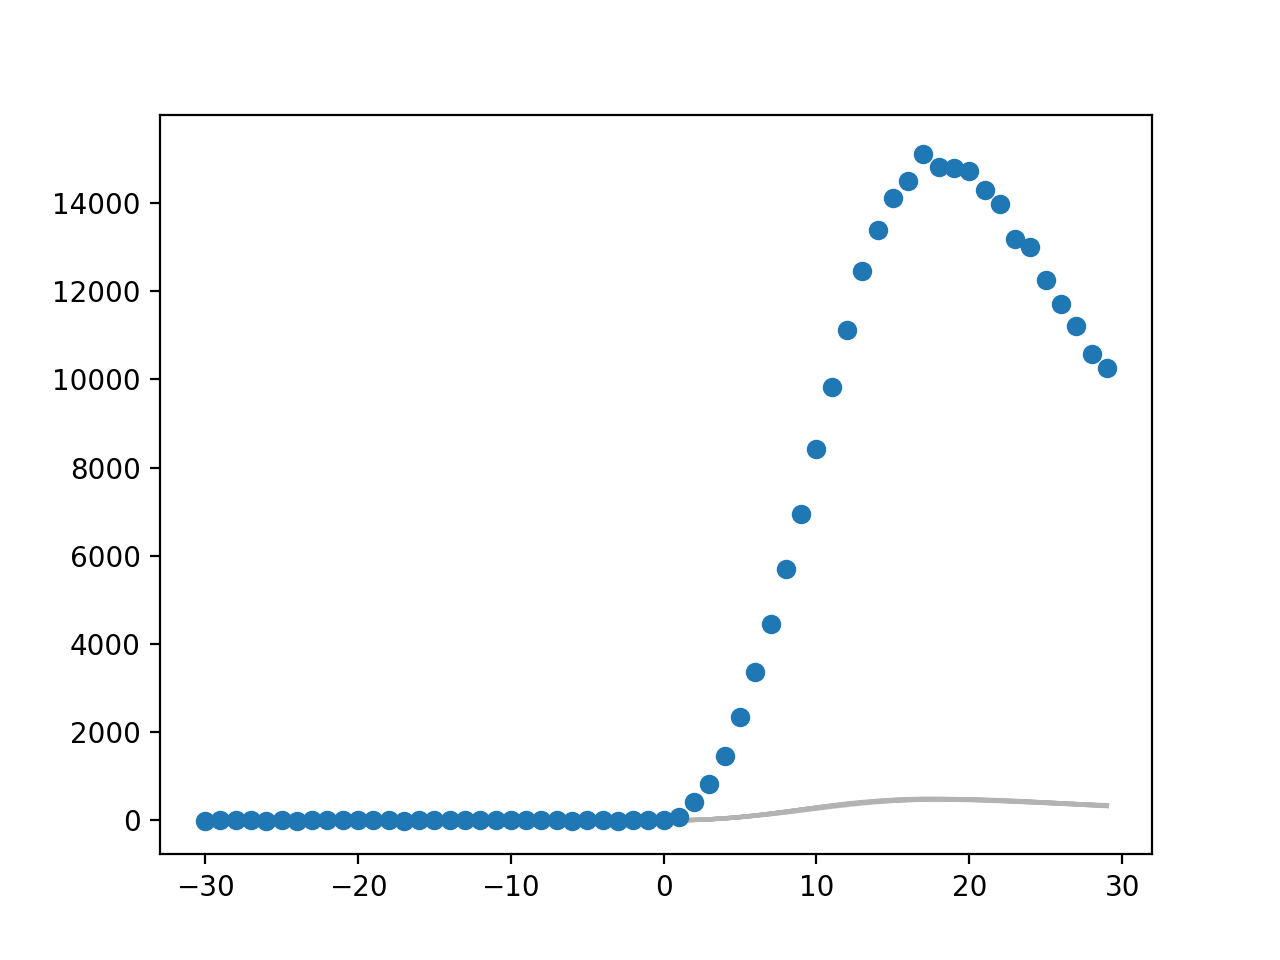

290
[-1.29467679e+00  3.50443586e+03 -7.33779980e+00  1.85761980e+01
  7.51702842e+00  5.22197211e+00  6.04204909e-01]
245
[-1.21047640e+00  2.73046589e+03 -3.62194455e-01  1.97031919e+01
  2.63683662e+00  2.84022951e+00  7.87144180e-01]
61
[ 7.40402592e-01  4.03417229e+03 -4.05625311e-01  2.49172160e+01
  2.49876732e+00  3.62126328e+00  6.05139381e-01]
377
[ 7.42993338e-01  2.80454257e+03 -4.78652603e-01  2.13157888e+01
  2.57025878e+00  3.01277565e+00  7.71765270e-01]
116
[-8.63355262e-02  3.37442533e+03  8.80717796e-02  2.20670264e+01
  2.46624018e+00  3.11097043e+00  6.90074348e-01]
468
[-1.13485202e+00  3.41971525e+03 -1.27390527e+00  2.54845974e+01
  2.69970770e+00  3.78397184e+00  6.66039516e-01]
340
[  0.73962111 665.1685974    0.84606232  15.41330279   1.66626995
   1.37881693   4.45421608]
98
[-3.92363715e-01  1.67976252e+03 -4.29329306e-01  1.80513451e+01
  2.51698044e+00  2.50948053e+00  1.10943999e+00]
499
[-1.17737875e+00  8.16014334e+02 -2.40103655e-03  1.62142313e+01
  

In [379]:
plt.figure()
plt.errorbar(t_obs, cnts, cnts_unc, fmt='o')
burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
max_post_model = burn_max_post[0] + f_t(t_obs[t_obs > 0], amplitude=burn_max_post[1], 
                                        t_0=burn_max_post[2], t_b=burn_max_post[3], 
                                        alpha_r=burn_max_post[4], alpha_d=burn_max_post[5], 
                                        s=burn_max_post[6])
plt.plot(t_obs[t_obs > 0], max_post_model, "0.7", alpha=0.7)

for samp_num in np.random.randint(0, len(sampler.chain[:,-1,:]), size=10):
    print(samp_num)
    sample = sampler.chain[:,-1,:][samp_num]
    print(sample)
    flux_fit = f_t(t_obs[t_obs > 0], amplitude=sample[1], t_0=sample[2], t_b=sample[3], 
                        alpha_r=sample[4], alpha_d=sample[5], s=sample[6])
    plt.plot(t_obs[t_obs > 0], flux_fit, "0.7", alpha=0.7)

# plt.ylim(0,4e4)

In [372]:
max_post_model

array([  1.58856574,  11.0955996 ,  26.9460451 ,  49.10770965,
        77.37813707, 111.31380898, 150.15703674, 192.7850408 ,
       237.70654257, 283.12659158, 327.0858558 , 367.65779931,
       403.16430968, 432.35899022, 454.53500155, 469.53843021,
       477.6970395 , 479.69496139, 476.4299221 , 468.88289959,
       458.01738372, 444.71311399, 429.73080693, 413.70047523,
       397.1253481 , 380.39461404, 363.80003405, 347.5532208 ,
       331.80175664])

<IPython.core.display.Javascript object>


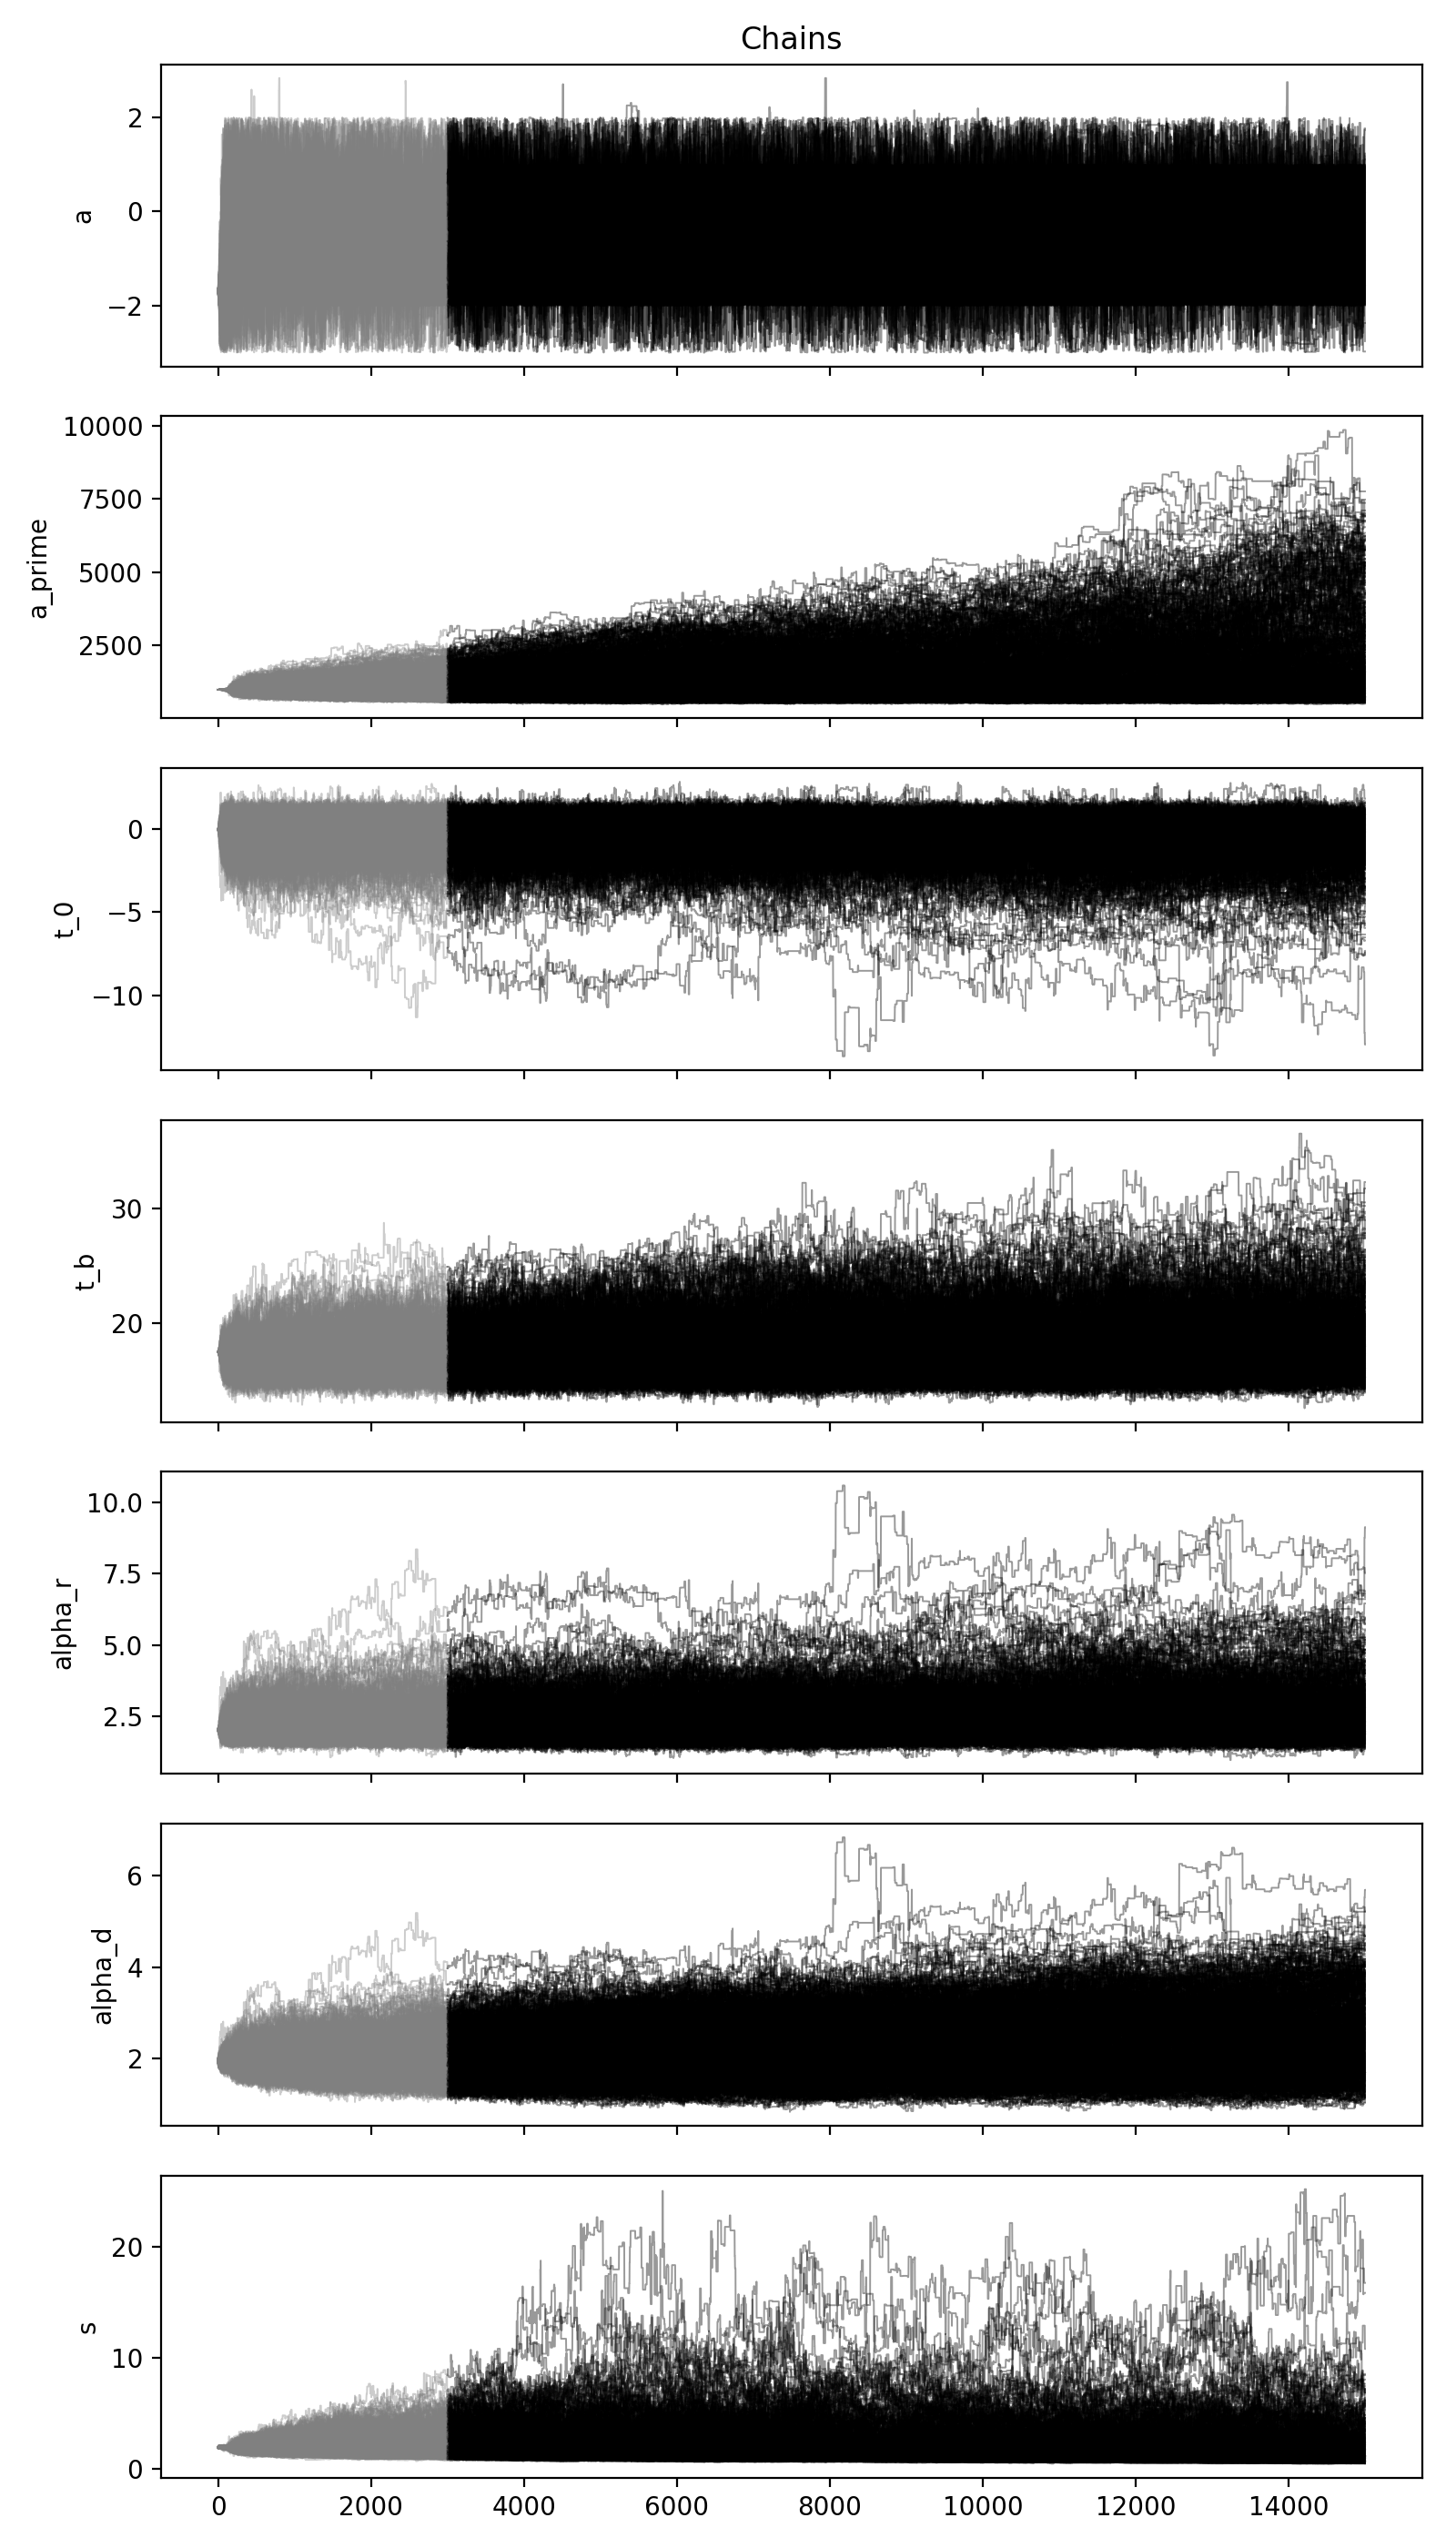

In [373]:
ax = plotChains(sampler, burnin, paramsNames)
plt.show()
plt.tight_layout()

In [403]:
makeCorner(sampler, burnin, paramsNames, truths=ground_truth)
plt.show()

NameError: name 'truthes' is not defined

Time to mess around a bit with understanding the autocorrelation length of the sampler. 

In [18]:
tau = sampler.get_autocorr_time()

In [20]:
np.mean(tau)*50

41152.54635587364

In [401]:
truths=[]
len(truths)

0

In [14]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, truths=truths)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    selected_walkers = np.random.choice(range(sampler.chain.shape[0]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.lnprobability[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.lnprobability[nburn:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=['a', 'a_prime', 't_0', 't_b', 'alpha_r', 'alpha_d', 's']

In [517]:
np.shape(sampler.lnprobability[:nburn,25])

(3000,)

In [141]:
t_obs=np.arange(-30,30)
cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=50)
def sn_lc_mcmc(sigma_sys, t_obs):
    
    cnts, cnts_unc = gen_zheng_lc(t_obs, sigma_sys=sigma_sys)
    
    t_data = t_obs
    f_data = cnts
    f_unc_data = cnts_unc

    #initial guess on parameters
    guess_0 = [0, 1e4, 0, 20, 2, 2, 1, 10]

    #number of walkers
    nwalkers = 100
    nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    ndim = len(guess_0)
    ncores=4

    #initial position of walkers
    pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data))
    nsamples = 500
    foo = sampler.run_mcmc(pos, nsamples)

    # run second burn in
    burn_max_post = sampler.chain[:,-1,:][np.argmax(sampler.lnprobability[-1,:])]
    pos = [burn_max_post + nfac * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(f_data, t_data, f_unc_data), threads = ncores)
    nsamples = 1000
    foo = sampler.run_mcmc(pos, nsamples)
    
    return sampler

In [143]:
%%timeit
sampler = sn_lc_mcmc(200, t_obs)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


8.86 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
import multiprocessing
from itertools import product
from functools import partial



In [145]:
%%timeit
t_obs=np.arange(-30,30)
pool = multiprocessing.Pool(4)
sampler1, sampler2, sampler3, sampler4 = pool.map(partial(sn_lc_mcmc, t_obs=t_obs), [3,5,50,316])

# pool.starmap(merge_names, product(names, repeat=2))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountere

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountere

11.4 s ± 446 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [138]:
sampler1.flatchain

array([[-2.75479485e+01,  9.77023896e+03,  5.71246881e+00, ...,
         9.35777893e+01,  1.20997732e+01,  2.77354671e+02],
       [-2.75605273e+01,  9.77026684e+03,  5.70664073e+00, ...,
         9.36007835e+01,  1.20398424e+01,  2.77341014e+02],
       [-2.75760153e+01,  9.77024922e+03,  5.74455682e+00, ...,
         9.36026611e+01,  1.20887608e+01,  2.77347646e+02],
       ...,
       [ 2.27923518e+01,  1.13082589e+04,  6.73343699e+00, ...,
         4.29285995e+01,  5.52993269e+02,  7.66779503e+02],
       [ 7.82691677e+01,  1.07577767e+04,  6.41818843e+00, ...,
         3.91708767e+01,  7.30133662e+02,  9.74482455e+02],
       [ 1.52014769e+02,  1.07766205e+04,  6.90407062e+00, ...,
         5.20785651e+01,  1.75441776e+02,  7.79726200e+02]])